In [1]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline
%load_ext snakeviz

import numpy as np
from scipy.optimize import minimize
from scipy.special import expit
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

import timeit

import pandas as pd

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

In [7]:
# Here are the initial values


# For test use
array12 = np.asarray(np.split(np.random.rand(1,60)[0],12))

[[ 0.78193249  0.74405463  0.05370159  0.64375254  0.9671223 ]
 [ 0.80076329  0.91518557  0.33013206  0.87704451  0.27513224]
 [ 0.06682722  0.62566131  0.6960552   0.50425531  0.26676161]
 [ 0.84152987  0.6574421   0.66056655  0.33425657  0.51805791]
 [ 0.55130428  0.54877911  0.02722155  0.36000264  0.94506057]
 [ 0.27276162  0.15587826  0.66411734  0.28773056  0.02330387]
 [ 0.39817375  0.87047702  0.57703081  0.02910282  0.6793279 ]
 [ 0.41591379  0.69201614  0.55686696  0.58659307  0.7747083 ]
 [ 0.04192126  0.54676091  0.31462627  0.58499502  0.58181971]
 [ 0.71115902  0.63971152  0.27552422  0.12488898  0.06121642]
 [ 0.84263665  0.55655689  0.85712789  0.29016308  0.31761533]
 [ 0.45020022  0.98342282  0.41708101  0.96441744  0.59613387]]


In [15]:
# Here is the activation function

def act(x):
    return expit(x)

In [17]:
# Density matrix in the forms that I wrote down on my Neutrino Physics notebook
# x is a real array of 12 arrays.

init = np.array([1.0,0.0,0.0,0.0])

def rho(x,ti,initialCondition):
    
    elem = np.ones(4)
    
    for i in np.linspace(0,3,4):
        elem[i] = np.sum(ti*x[i*3]*act(ti*x[i*3+1] + x[i*3+2]) )
    
    return init + elem
    

In [21]:
rho(array12,0,init)

array([ 1.,  0.,  0.,  0.])

In [23]:
# Hamiltonian of the problem, in terms of four real components

hamil = 1.0/2*np.array( [  -np.cos(0.2),np.sin(0.2) , np.sin(0.2),np.cos(0.2) ] )
print hamil

[-0.49003329  0.09933467  0.09933467  0.49003329]


In [28]:
# Cost function for each time step

def rhop(x,ti,initialCondition):
    
    rhoprime = np.zeros(4)
    

    
    for i in np.linspace(0,3,4):
        rhoprime[i] = np.sum(x[i*3] * (act(ti*x[i*3+1] + x[i*3+2]) ) ) +  np.sum( ti*x[i*3]* (act(ti*x[i*3+1] + x[i*3+2]) ) * (1 - (act(ti*x[i*3+1] + x[i*3+2])  ) )* x[i*3+1]  )
        
    
    return rhoprime


def costi(x,ti,initialCondition):
    
    rhoi = rho(x,ti,initialCondition)
    rhopi = rhop(x,ti,initialCondition)
    
    costTemp = np.zeros(4)
    
    costTemp[0] = (rhopi[0] + 2.0*rhoi[2]*hamil[1] )**2
    costTemp[1] = ( rhopi[1] - 2.0*rhoi[2]*hamil[0] )**2
    costTemp[2] = ( rhopi[2] + 2.0*rhoi[1]*hamil[0] + hamil[1] * (rhoi[3] - rhoi[0] ) )**2
    costTemp[3] = ( rhopi[3] -2.0*rhoi[2]*hamil[1] )**2
    
    return np.sum(costTemp)
    

In [31]:
costi(array12,0,init)

9.9862844576503687

In [32]:
def cost(x,t,initialCondition):
    
    costTotal = map(lambda t: costi(x,t,initialCondition),t)
    
    return np.sum(costTotal)

In [33]:
cost(array12,np.array([0,1,2]),init)

109.41690525747632

In [111]:
# with ramdom initial guess

initGuess = np.asarray(np.split(np.random.rand(1,60)[0],12))
endpoint = 2
tlin = np.linspace(0,endpoint,11)

costF = lambda x: cost(x,tlin,init)

startSLSQP = timeit.default_timer()
costvFResultSLSQP = minimize(costF,initGuess,method="SLSQP",tol=1e-10)
stopSLSQP = timeit.default_timer()

print stopSLSQP - startSLSQP

print costvFResultSLSQP

43.8397769928
  status: 9
 success: False
    njev: 101
    nfev: 6292
     fun: 0.0047586988786499536
       x: array([-0.01274929,  4.42549452, -2.22399167, -3.25705347,  0.44030504,
       -4.82624925,  0.07210269, -2.81341793,  6.385534  ,  0.04279662,
        1.09059866, -3.18706065,  0.61994826,  0.96756294,  0.60929092,
        0.23839364,  0.45364599,  0.18426882,  0.30242425,  0.96719724,
        0.13016584,  0.9192801 ,  0.116001  ,  0.46777053,  0.17497595,
        0.96035958,  0.21763616,  0.73997804,  0.88071662,  0.1620245 ,
        0.66904538,  0.66084959,  0.89772078,  0.49020208,  0.67802378,
        0.53307714,  0.59867975,  0.16864478,  0.4257949 ,  0.5364126 ,
        0.78476644,  0.4910997 ,  0.834945  ,  0.45061367,  0.16736545,
        0.42579168,  0.16877594,  0.98282177,  0.08852038,  0.12633737,
        0.50922379,  0.93146299,  0.66505978,  0.33157336,  0.05408186,
        0.04504323,  0.27311737,  0.27651656,  0.47313653,  0.12806564])
 message: 'Iteration l

In [112]:
xmid = costvFResultSLSQP.get("x")

startSLSQP = timeit.default_timer()
costvFResultSLSQP = minimize(costF,xmid,method="SLSQP",tol=1e-30,options={"ftol":1e-30,"maxiter":1000})
stopSLSQP = timeit.default_timer()

print stopSLSQP - startSLSQP

print costvFResultSLSQP

98.4179999828
  status: 0
 success: True
    njev: 234
    nfev: 14598
     fun: 0.00016073816213794123
       x: array([-0.01486401,  2.25493868, -1.84543911, -0.07335087,  2.2548026 ,
       -1.84421662,  0.10454078, -1.64040244,  2.99923129,  0.01486399,
        2.2549433 , -1.84544286,  0.61994826,  0.96756294,  0.60929092,
        0.23839364,  0.45364599,  0.18426882,  0.30242425,  0.96719724,
        0.13016584,  0.9192801 ,  0.116001  ,  0.46777053,  0.17497595,
        0.96035958,  0.21763616,  0.73997804,  0.88071662,  0.1620245 ,
        0.66904538,  0.66084959,  0.89772078,  0.49020208,  0.67802378,
        0.53307714,  0.59867975,  0.16864478,  0.4257949 ,  0.5364126 ,
        0.78476644,  0.4910997 ,  0.834945  ,  0.45061367,  0.16736545,
        0.42579168,  0.16877594,  0.98282177,  0.08852038,  0.12633737,
        0.50922379,  0.93146299,  0.66505978,  0.33157336,  0.05408186,
        0.04504323,  0.27311737,  0.27651656,  0.47313653,  0.12806564])
 message: 'Optimizati

In [113]:
xresult = costvFResultSLSQP.get("x")
#xresult = np.array([-1.37886409,  2.81454922, -0.3571002 ,  0.02582831, -1.05414931,
#       -1.52308153, -2.24747468,  0.33947049, -0.32310112, -1.43887103,
#        0.81176258,  0.05139705, -1.02669705, -0.97236805, -0.27536667,
#        0.34860447, -1.06962772,  0.89978175,  2.39662887, -1.45165477,
#       -1.54636469, -2.79921374, -1.30335793, -0.62844367, -3.04440811,
#       -2.74566393, -2.16222918, -1.60535643, -0.77298204,  0.13848754,
#       -0.36544212,  1.23901581, -0.80586367, -0.30212561, -1.02818302,
#       -2.82928373, -0.80776632, -2.90056107, -2.42432246, -2.87572658,
#       -0.8645904 , -0.59526987, -1.87029203, -1.60957508, -1.83106839,
#        1.07020356, -0.84892132, -0.97053555, -0.2005098 , -0.72422578,
#       -3.32948549, -4.99349947, -3.46242765, -3.52481528, -3.36820222,
#       -4.1848837 , -1.90748847, -2.09206645, -4.10831718,  2.76094325])

print xresult

[-0.01486401  2.25493868 -1.84543911 -0.07335087  2.2548026  -1.84421662
  0.10454078 -1.64040244  2.99923129  0.01486399  2.2549433  -1.84544286
  0.61994826  0.96756294  0.60929092  0.23839364  0.45364599  0.18426882
  0.30242425  0.96719724  0.13016584  0.9192801   0.116001    0.46777053
  0.17497595  0.96035958  0.21763616  0.73997804  0.88071662  0.1620245
  0.66904538  0.66084959  0.89772078  0.49020208  0.67802378  0.53307714
  0.59867975  0.16864478  0.4257949   0.5364126   0.78476644  0.4910997
  0.834945    0.45061367  0.16736545  0.42579168  0.16877594  0.98282177
  0.08852038  0.12633737  0.50922379  0.93146299  0.66505978  0.33157336
  0.05408186  0.04504323  0.27311737  0.27651656  0.47313653  0.12806564]


In [114]:
rho(xresult,10,init)

array([  8.51359883e-01,  -7.33508745e-01,   1.57636730e-06,
         1.48639912e-01])

In [115]:
plttlin=np.linspace(0,endpoint,100)
pltdata11 = np.array([])
for i in plttlin:
    pltdata11 = np.append(pltdata11 ,rho(xresult,i,init)[0] )
    
print pltdata11

[ 1.          0.9999574   0.99991142  0.99986188  0.99980862  0.99975148
  0.99969026  0.9996248   0.99955492  0.99948043  0.99940116  0.99931693
  0.99922754  0.99913283  0.99903262  0.99892672  0.99881497  0.9986972
  0.99857324  0.99844294  0.99830615  0.99816271  0.9980125   0.99785539
  0.99769126  0.99752     0.99734152  0.99715574  0.99696259  0.99676201
  0.99655395  0.9963384   0.99611534  0.99588477  0.99564671  0.9954012
  0.99514829  0.99488804  0.99462054  0.99434589  0.9940642   0.9937756
  0.99348023  0.99317826  0.99286984  0.99255517  0.99223444  0.99190786
  0.99157563  0.99123799  0.99089516  0.99054739  0.99019491  0.98983798
  0.98947684  0.98911176  0.98874299  0.98837077  0.98799538  0.98761705
  0.98723605  0.98685261  0.98646699  0.98607941  0.98569011  0.98529933
  0.98490726  0.98451414  0.98412016  0.98372551  0.98333039  0.98293498
  0.98253944  0.98214394  0.98174863  0.98135365  0.98095914  0.98056523
  0.98017203  0.97977965  0.97938819  0.97899775  0.97

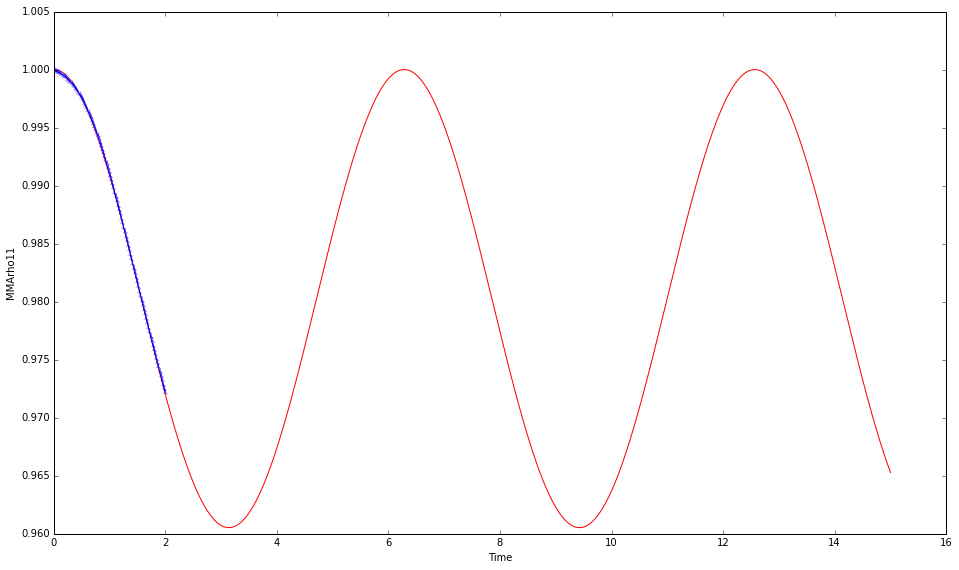

In [116]:
MMA_optmize_Vac_pltdata = np.genfromtxt('./assets/homogen/MMA_optmize_Vac_pltdata.txt', delimiter = ',')

plt.figure(figsize=(16,9.36))
plt.ylabel('MMArho11')
plt.xlabel('Time')
plt.plot(np.linspace(0,15,4501),MMA_optmize_Vac_pltdata,"r-",label="MMAVacrho11")
plt.plot(plttlin,pltdata11,"b4-",label="vac_rho11")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="MMA-rho11-Vac-80-60")